# Regression exploration

In this problem set you will explore working with regression. The first part of the notebook will define basic functions and import data that we need. Note in particular that I load `pandas` and `seaborn`. Both of these packages might have to be installed before you can run this notebook - you can modify the code below to not use them but as they are both powerful and useful I recommend you get them working.

Pandas is a library designed to handle data in a flexible way. It is derived from `R`'s data frames and Pandas is particularly nice for moderate sized datasets and dataset that mix datatypes. To learn more about `pandas` you can check out the project web page: [http://pandas.pydata.org/](http://pandas.pydata.org/). 

Seaborn is a visualisation package particularly suited for statistical data. It builds on `matplotlib` but adds functionality and improves the default appearance (although not all defaults are that great IMHO).There is plenty of information on this on the Seaborn web page: [https://seaborn.pydata.org/index.html](https://seaborn.pydata.org/index.html)

In [51]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting import hist
import seaborn as sns
import pandas as pd
import sys

# Pickle is actually the name in python 3, but python 2 has cPickle - so this 
# allows the code to work on both.
try:
    import cPickle
except:
    import _pickle as cPickle
from sklearn.linear_model import Ridge, Lasso

# The matplotlib inline special command must be commented out if you run this as 
# a script or on the ipython/python command line.
%matplotlib inline

In [2]:
# This sets the default appearance of seaborn and its colour palette
sns.set(style="white")
sns.set_palette('colorblind')

In [3]:
def pickle_to_file(data, fname):
    """Save a variable simply to a file"""
    try:
        fh = open(fname, 'w')
        cPickle.dump(data, fh)
        fh.close()
    except:
        print("Pickling failed!", sys.exc_info()[0])

def pickle_from_file(fname):
    """Restore a variable saved with pickle_to_file"""
    try:
        fh = open(fname, 'r')
        data = cPickle.load(fh)
        fh.close()
    except:
        print("Loading pickled data failed!", sys.exc_info()[0])
        data = None

    return data

In [4]:
# This reads in data on stellar sources from the SDSS.
# If running this on a computer without the setup recommended on blackboard, it will
# download the data from the net the first time called.
data = fetch_sdss_sspp()

[========================================]  37.46Mb / 37.46Mb   


It can be useful to know what is in the data array! One good way is to check the [documentation of fetch_sdss_spp](http://www.astroml.org/modules/generated/astroML.datasets.fetch_sdss_sspp.html), another is to print `data.dtype.names` which will show you the name of the columns in the data.

In [5]:
print(data.dtype.names)

('ra', 'dec', 'Ar', 'upsf', 'uErr', 'gpsf', 'gErr', 'rpsf', 'rErr', 'ipsf', 'iErr', 'zpsf', 'zErr', 'pmL', 'pmB', 'pmErr', 'mjd', 'plate', 'fiber', 'SNR', 'FeH', 'FeHErr', 'Teff', 'TeffErr', 'logg', 'loggErr', 'alphFe', 'alphFeErr', 'radVel', 'radVelErr')


In [6]:
# Extract some data. 
ug = data['upsf']-data['gpsf']
gr = data['gpsf']-data['rpsf']
ri = data['rpsf']-data['ipsf']
iz = data['ipsf']-data['zpsf']
T = data['Teff']

In [11]:
# Understand what the line below does! Try without the transpose and see the shape.
X = np.vstack((ug, gr, ri, iz, T)).T
M = np.vstack((ug, gr, ri, iz)).T
M.shape

(327260, 4)

## Visualisation of the data

A good way to visualise data like this is to use a pair plot grid - this is provided by Seaborn in the `PairGrid` function. This allows lower and upper and diagonals to show different things. The lower half and diagonals show Kernel Density plots - we will come back to these later in the course - for now think of them as smooth versions of 2D and 1D histograms respectively. (this does take a bit to run btw! but to make it quicker I only use the first 1000 points).

/home/solene/anaconda4/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


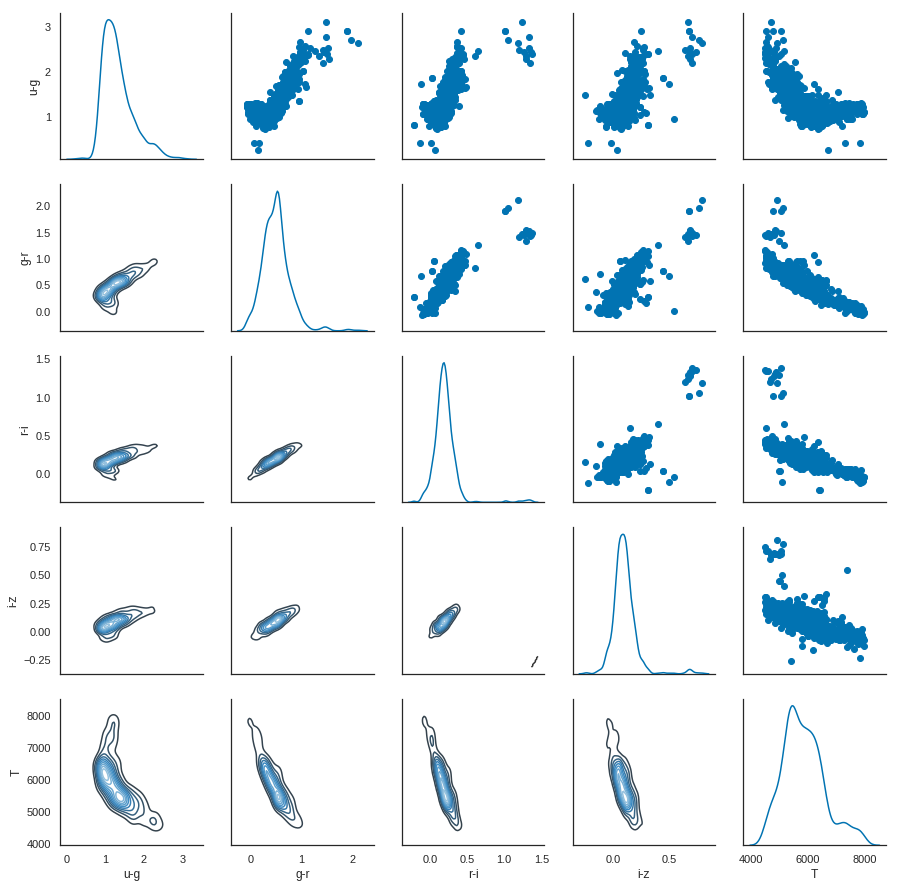

In [12]:
# Here I make a Pandas's DataFrame 
df = pd.DataFrame(X[0:1000, :], columns=['u-g', 'g-r', 'r-i', 'i-z', 'T'])
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)

There is plenty of co-linearity in this data. Let me now assume that we can write

$$T = \theta_0 + \theta_1 (u-g) + \theta_2 (g-r) + \theta_3 (r-i) + \theta_5 (i-z) $$

and we want to constrain $\theta$.

Your task now is to do this for different types of regression. The foundation of the code is provided in the lecture notes of lecture 1 - feel free to use that!

## Problem 1: Regular linear regression

a) Fit a model to the data to predict $T$, find $\theta$ and plot the residuals between the best fit regression line and the true values as a function of the temperature $T$. What do you conclude about your model?


b) Pick 8 stars at random from the sample and redo the fit. Do this twice - are the best fit lines consistent? [different people will reach different conclusions here!]

In [41]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def Teff_model(ws, ug=ug, gr=gr, ri=ri, iz=iz):
    w1, w2, w3, w5 = ws
    return w1*ug + w2*gr + w3*ri + w5*iz

# coefficients w = [w1, w2, w3, w5],  # intercept w0
# Features
X = np.array([ug, gr, ri, iz]).T
X.shape
# Teff values
y = T
print(X.shape[0], y.shape[0])

# Splitting in train and test sets
X_train, X_test, Teff_train, Teff_test = train_test_split(X, y, test_size=0.33, random_state=0)

regr = linear_model.LinearRegression()
regr.fit(X_train, Teff_train)

# Make predictions using the testing set
Teff_pred = regr.predict(X_test)

# Coefficients of the regression (w0, w1, w2, w3, w5)
print('Coefficients: \n', regr.coef_)
# 
print("Mean squared error: %.2f" % mean_squared_error(Teff_test, Teff_pred))
print('Variance score: %.2f' % r2_score(Teff_test, Teff_pred))

327260 327260
Coefficients: 
 [  247.56546 -2609.92     -817.22766   367.5068 ]
Mean squared error: 114871.09
Variance score: 0.75


ValueError: shapes (40,1) and (4,) not aligned: 1 (dim 1) != 4 (dim 0)

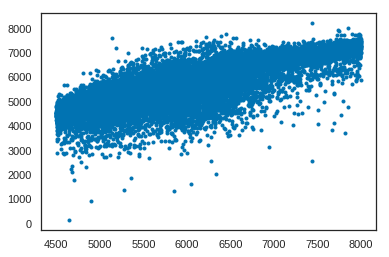

In [81]:
# Plotting the residuals
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
plt.figure()
# plt.plot(Teff_test, (Teff_test-Teff_pred), '.')
# plt.plot(T, Teff_model(regr.coef_), 'k.')
# plt.plot(X_test, Teff_pred, '.')
plt.plot(Teff_test, Teff_pred, '.')


Teff_sample = np.linspace(4500, 8000, num=40)
Teff_sample = Teff_sample[:,np.newaxis]
#Teff_sample = Teff_test[:40]
# X_test_sample = X_test[:40, :]
Teff_sample_pred = regr.predict(X_test_sample)
# plt.plot(Teff_sample, Teff_sample_pred)
plt.plot(Teff_sample, regr.predict(Teff_sample))

print(X_test_sample.shape)
print(Teff_sample.shape)

## Problem 2: Ridge regression

Repeat a) & b) from problem 1 for RidgeRegression. How does the answer for b) differ from that for regular linear regression.

## Problem 3: LASSO regression

Finally repeat the tasks in problem 1 for LASSO regression. Reflect on how the answer for b) changes relative to the other two questions.

In the lecture we saw that for a sufficiently large regularisation parameter, $\lambda$, the only remaining term is the one for $\theta_2$ - can you visually explain why this is?